## LL

In [1]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [5]:
save_dir = '/home/hanna/images_simple_statsmodels/'

sat_dir = '/home/hanna/lagrings/satelite_coordinates/msthesis/'

ex_fil = glob.glob(save_dir + '*indexes_test*.json')[0]
with open(ex_fil, 'r') as f:
    data_grid = json.load(f)

In [30]:
satfil = glob.glob(sat_dir + '*nc')[-1]

In [31]:
satfil

'/home/hanna/lagrings/satelite_coordinates/msthesis/cloud_mask.nc'

In [13]:
def read_dlon_dlat(save_dir):
    nc_files = glob.glob(save_dir+'*cell*.json')
    #print(nc_files)
    with open(nc_files[-1]) as f:
        d =  json.load(f)
        
    d_phi      = d['dphi'] 
    d_theta    = d['dtheta'] 
    cell_areas = d['cell_area']
    lat_array  = d['lat'] 
    lon_array  = d['lon']
    return d_phi, d_theta, cell_areas, lat_array, lon_array

In [33]:
def clean_file(satfil):
    if satfil.split('.')[-1] == 'grb':
        cloudMask = xr.open_dataset(satfil, engine = 'cfgrib')
        o = cloudMask['p260537'].values.reshape( (3712, 3712) )
    else:
        cloudMask = xr.open_dataset(satfil)
        #print(cloudMask)
        o = cloudMask['cloudMask'].values.reshape( (3712, 3712) )
    o[o>=3.0]=np.nan
    o[o==1.0]=0
    o[o==2.0]=1.0
    return o

In [44]:
def area_grid_cell(c_lat, d_lat, d_lon):
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)

In [56]:
def get_dict_with_all_keys():
    ex_fil = glob.glob(save_dir + '*ERA5*grid*changes_to_indexes_from*.json')
    merged_dict = {}
    for fil in ex_fil:
        with open(fil, 'r') as f:
            data_grid = json.load(f)
        merged_dict.update(data_grid)   
    return merged_dict

In [57]:
def calc_fraction_one_cell(lat = '30.25', lon = '19.25', cmk = None, data = None):

    if data:
        ## Improvements : This should read the files. 
        ex = data[lat][lon]
        fraction = 0

        ERA_area = area_grid_cell(float(lat), 0.25/2, 0.25/2)
        SAT_area = 0
        #cmk = np.random.randint(low = 0, high=2, size = len(lat_array))

        for key, item in ex.items():
            index = item['index']
            area  = item['area']

            if len(index) == len(area):
                # , "len index, len are = {}, {}".format(len(index), len(area))
                SAT_area += np.sum(area)
                fraction += np.sum( np.array(area)*np.array(cmk[index]) )
            else:
                #print('lat {}, lon {}'.format(lat, lon))
                return np.nan, (lat, lon)
            
        return fraction/SAT_area*ERA_area, None
    else:
        print('Please send data as a attribute.')
        return

In [65]:
def compute(satfil):
    o = clean_file(satfil)
    d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(save_dir)
    ex_fil = glob.glob(save_dir + '*ERA5*grid*changes_to_indexes_from*.json')
    #fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

    clouds = o.reshape(-1)

    _all = {}
    fractions = {}

    #ex_fil = glob.glob(save_dir + '*indexes_test*.json')[0]
    for fil in ex_fil:
        with open(fil, 'r') as f:
            data_grid = json.load(f)
        _all.update(data_grid)

    lats = list(_all.keys())    
    lons = list(_all[lats[0]].keys())
    
    pairs = []

    lons = np.sort([float(f) for f in lons])
    lats = np.sort([float(f) for f in lats])

    for lat in lats:
        fractions[str(lat)] = {}
        for lon in lons:
            a, tup = calc_fraction_one_cell(lat = str(lat), 
                                            lon = str(lon), 
                                            cmk = clouds, 
                                            data = _all)
            fractions[str(lat)][str(lon)] = a
            if tup:
                pairs.append(tup)
    import pandas as pd
    
    return pd.DataFrame.from_dict(fractions), pairs

In [66]:
#for fil in glob.glob(sat_dir + '*2012*10*.grb')[:100]:
#    sns.heatmap(compute(fil))
#    plt.show()

In [67]:
import seaborn as sns
#sns.heatmap(o)

In [68]:
df, pairs = compute(satfil)

/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


# Study what happens in pairs on a index level

In [79]:
def add(a, b):
    return np.abs(a) + np.abs(b)

def subtract(a, b):
    return np.abs(a) - np.abs(b)

In [80]:
lat, lon = pairs[0]

In [109]:
#lats = np.arange(30, 56, 0.25) # numpy split these.
#lons = np.arange(-15, 30, 0.25) # numpy split these 

d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(save_dir)
#51.5 lon 5.75
lats = [51.5]
lons = [5.75]

c_lat = np.array(lat_array)
c_lon = np.array(lon_array) 
d_theta = np.array(d_theta) 
d_phi = np.array(d_phi)

write_fil = True
era_step = 0.25

data = {}
counter = 0
for lat in lats:
    data[str(lat)] = {}
    counter+=1
    for lon in lons:
        data[str(lat)][str(lon)] = {}
        era_AREA = area_grid_cell(lat, era_step/2, era_step/2)
        print("lat = {}, lon = {}".format(lat, lon))
        era_up    = lat + era_step/2
        era_down  = lat - era_step/2
        era_left  = lon - era_step/2
        era_right = lon + era_step/2

        # to ensure correct sign
        cmk_left  = c_lon - np.abs(d_phi)   #- era_right
        cmk_right = c_lon + np.abs(d_phi)   #- era_left

        # TODO : Sjekk d theta og lignende.
        cmk_up    = c_lat + np.abs(d_theta) #- era_down
        cmk_down  = c_lat - np.abs(d_theta) #- era_up

        data[str(lat)][str(lon)]['centre'] = {}
        data[str(lat)][str(lon)]['down'] = {}
        data[str(lat)][str(lon)]['up'] = {}
        data[str(lat)][str(lon)]['right'] = {}
        data[str(lat)][str(lon)]['left'] = {}
        data[str(lat)][str(lon)]['corner'] = {}

        idx_left_boundary  = np.intersect1d(np.argwhere(cmk_right > era_left),  np.argwhere(cmk_left < era_left) )
        idx_right_boundary = np.intersect1d(np.argwhere(cmk_right > era_right), np.argwhere(cmk_left < era_right) )
        idx_up_boundary    = np.intersect1d(np.argwhere(cmk_up > era_up),       np.argwhere(cmk_down < era_up) )
        idx_down_boundary  = np.intersect1d(np.argwhere(cmk_up > era_down),     np.argwhere(cmk_down < era_down) )

        #data[str(lat)][str(lon)]['down']['index']  = idx_down_boundary.reshape(-1).tolist()
        #data[str(lat)][str(lon)]['up']['index']    = idx_up_boundary.reshape(-1).tolist()
        #data[str(lat)][str(lon)]['left']['index']  = idx_left_boundary.reshape(-1).tolist()
        #data[str(lat)][str(lon)]['right']['index'] = idx_right_boundary.reshape(-1).tolist()

        idx_lower_right_corner = np.intersect1d(idx_down_boundary, idx_right_boundary)
        idx_lower_left_corner  = np.intersect1d(idx_down_boundary, idx_left_boundary)
        idx_upper_left_corner  = np.intersect1d(idx_up_boundary, idx_left_boundary)
        idx_upper_right_corner = np.intersect1d(idx_up_boundary, idx_right_boundary)

        corner_idx         = np.concatenate([idx_lower_right_corner, idx_lower_left_corner,
                                             idx_upper_left_corner, idx_upper_right_corner]) # corner idx
        
        data[str(lat)][str(lon)]['corner']['index'] = corner_idx.reshape(-1).tolist()
        #assert len(corner_idx) == 4, "Not correct number of corners, nbr = {}.".format(len(corner_idx))

        # TODO add new centre corners. And calculate  
        llc_dlat = subtract(cmk_up[idx_lower_left_corner], era_down)/2
        llc_dlon = subtract(era_left, cmk_right[idx_lower_left_corner])/2
        llc_lat  = era_down + llc_dlat

        llc_area = area_grid_cell(llc_lat, llc_dlat, llc_dlon)
        print("len idx {}".format(len(idx_lower_left_corner)))
        print("area lower left area len {}\n".format( len(llc_area) ))

        lrc_dlat = subtract(cmk_up[idx_lower_right_corner], era_down)/2
        lrc_dlon = subtract(cmk_left[idx_lower_right_corner], era_right)/2

        lrc_lat  = era_down + lrc_dlat
        lrc_area = area_grid_cell(lrc_lat, lrc_dlat, lrc_dlon)
        print("len idx {}".format(len(idx_lower_right_corner)))
        print("area lower right area len {}\n".format( len(lrc_area) ))
        #print("area lower right area {}".format(h/era_AREA))

        ulc_dlat = subtract(era_up, cmk_down[idx_upper_left_corner])/2
        ulc_dlon = subtract(era_left, cmk_right[idx_upper_left_corner])/2
        ulc_lat = era_up - ulc_dlat
        ulc_area = area_grid_cell(ulc_lat, ulc_dlat, ulc_dlon)
        print("len idx {}".format(len(idx_upper_left_corner)))
        print("area lower left area len {}\n".format( len(ulc_area) ))

        #print("area upper left area {}".format(i/era_AREA))

        urc_dlat = subtract(era_up, cmk_down[idx_upper_right_corner])/2
        print(urc_dlat)
        print("len idx urc dlat {}".format(len(urc_dlat)))
        urc_dlon = subtract(cmk_left[idx_upper_right_corner], era_right)/2
        print("len idx urc dlon {}".format(len(urc_dlon)))
        urc_lat  = era_up - urc_dlat
        print("era up {}".format(era_up))
        print(urc_lat)
        print("len idx urc lat {}".format(len(urc_lat)))
        urc_area = area_grid_cell(urc_lat, urc_dlat, urc_dlon)
        print("len idx {}".format(len(idx_upper_right_corner)))
        print("area upper right area len \n{}".format( len(urc_area) ))

        #print("area upper right area {}".format(j/era_AREA))
        #print("SUM corners {}".format((i+j+h+f)/era_AREA))

        corner_areas = np.array([lrc_area, llc_area, ulc_area, urc_area])
        # TODO why are you sometimes 6 not 5
        data[str(lat)][str(lon)]['corner']['area'] = np.concatenate(corner_areas).reshape(-1).tolist()

        #assert len(corner_idx) == 4, "Expected four corners, got {}".format(len(corner_idx))

        #max_lon, min_lon = np.max(c_lon[corner_idx]), np.min(c_lon[corner_idx])
        #max_lat, min_lat = np.max(c_lat[corner_idx]), np.min(c_lat[corner_idx])

        # Removes Corners
        # TODO test if this removes indecies. 
        idx_down_boundary = np.array(idx_down_boundary)[np.isin(idx_down_boundary, corner_idx, invert = True)]
        idx_up_boundary = np.array(idx_up_boundary)[np.isin(idx_up_boundary, corner_idx, invert = True)]
        idx_left_boundary = np.array(idx_left_boundary)[np.isin(idx_left_boundary, corner_idx, invert = True)]
        idx_right_boundary = np.array(idx_right_boundary)[np.isin(idx_right_boundary, corner_idx, invert = True)]    
        #idx_down_boundary = np.array(idx_down_boundary)[np.isin(idx_down_boundary, corner_idx invert = True)]
                       
        # subsection left boundary OLD
        low_bound = np.argwhere(cmk_down[idx_left_boundary] < era_up  )
        up_bound  = np.argwhere(cmk_up[idx_left_boundary]   > era_down )
        sub_section_left = np.intersect1d(low_bound, up_bound)

        
        idx_l = np.array(idx_left_boundary)[np.array(sub_section_left)]
        data[str(lat)][str(lon)]['left']['index'] = idx_l[np.isin(idx_l, corner_idx, invert = True)].tolist()

        # subsection right boundary
        low_bound = np.argwhere( cmk_down[idx_right_boundary] < era_up )
        up_bound  = np.argwhere( cmk_up[idx_right_boundary] > era_down)
        sub_section_right = np.intersect1d(low_bound, up_bound)
        
        idx_r = np.array(idx_right_boundary)[np.array(sub_section_right)]
        data[str(lat)][str(lon)]['right']['index'] = idx_r[np.isin(idx_r, corner_idx, invert = True)].tolist()
        #sub_section_right.reshape(-1).tolist()

        # Subsection Down Boundary
        one = np.argwhere(cmk_left[idx_down_boundary]  > era_left)
        two = np.argwhere(cmk_right[idx_down_boundary] < era_right)
        sub_section_down = np.intersect1d(one, two)
        idx_d = np.array(idx_down_boundary)[np.array(sub_section_down)]
        
        data[str(lat)][str(lon)]['down']['index'] =  idx_d[np.isin(idx_d, corner_idx, invert = True)].tolist()
        #sub_section_down.reshape(-1).tolist()

        # subsection up boundary
        one = np.argwhere( cmk_left[idx_up_boundary]  > era_left)
        two = np.argwhere( cmk_right[idx_up_boundary] < era_right)
        sub_section_up = np.intersect1d(one, two)
        idx_u = np.array(idx_up_boundary)[np.array(sub_section_up)]
        data[str(lat)][str(lon)]['up']['index'] = idx_u[np.isin(idx_u, corner_idx, invert = True)].tolist()
        #sub_section_up.reshape(-1).tolist()

        # test that these are empty
        t1 = np.intersect1d(idx_d, idx_u)
        t2 = np.intersect1d(idx_r, idx_l)
        # assert len(t1) == len(t2) == 0, "intercept up down  {}, intersect left right {}.".format(t1, t2)

        if len(t1) != 0:
            print("\n Problem up, down lat {} lon {}. \n".format(lat, lon))


        if len(t2) != 0:
            print("\n Problem left, right lat {} lon {}. \n".format(lat, lon))
        # Calculate Boundaries

        # AREA left boundary
        dlon_lf = subtract(cmk_right[idx_left_boundary][sub_section_left], era_left)/2 
        dlat_lf = d_theta[idx_left_boundary][sub_section_left]
        lat_lf  = c_lat[idx_left_boundary][sub_section_left]
        #lon_lf  = c_lon[idx_left_boundary][sub_section_left]
        
        left_areas = area_grid_cell(lat_lf, dlat_lf, np.abs(dlon_lf))
        data[str(lat)][str(lon)]['left']['area'] = left_areas.reshape(-1).tolist()

        a = np.sum(left_areas)

        #fraction_left = (cloud_mask_array[idx_left_boundary][sub_section_left]*area_grid_cell(lat_lf,
        #                                                                                      dlat_lf,                                                                                  
        #                                                                                      dlon_lf)/era_AREA).sum()
        #data[str(lat)][str(lon)]['left']['fraction'] = fraction_left.tolist()   
        # AREA right boundary
        dlon_rb = subtract(era_right, cmk_left[idx_right_boundary][sub_section_right])/2
        dlat_rb = d_theta[idx_right_boundary][sub_section_right]
        lat_rb  = c_lat[idx_right_boundary][sub_section_right]
        #lon_rb = c_lon[idx_right_boundary][sub_section_right]
        right_area = area_grid_cell(lat_rb, dlat_rb, np.abs(dlon_rb)) 
        data[str(lat)][str(lon)]['right']['area'] = right_area.ravel().tolist()
        b = np.sum(right_area)

        #fraction_right = (cloud_mask_array[idx_right_boundary][sub_section_right]*area_grid_cell(lat_rb,
        #                                                                                        dlat_rb,
        #                                                                                         dlon_rb)/era_AREA).sum()
        #data[str(lat)][str(lon)]['right']['fraction'] = fraction_right.tolist()
        # AREA down boundary
        dlat_down = subtract(era_down, cmk_up[idx_down_boundary][sub_section_down])/2
        lat_down = era_down + dlat_down
        dlon_down = d_phi[idx_down_boundary][sub_section_down]
        #lon_down =  c_lon[idx_down_boundary][sub_section_down]
        down_area = area_grid_cell(lat_down, dlat_down, dlon_down)
        c = np.sum(down_area)
        data[str(lat)][str(lon)]['down']['area'] = down_area.reshape(-1).tolist()
        #fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
        #                                                                                      dlat_down,
        #                                                                                      dlon_down)/era_AREA).sum()
        #data[str(lat)][str(lon)]['down']['fraction'] = fraction_down.tolist()
        # AREA up
        dlat_up = subtract(era_up, cmk_down[idx_up_boundary][sub_section_up])/2
        lat_up = era_up - dlat_up
        #lon_up = c_lon[idx_up_boundary][sub_section_up]
        dlon_up = d_phi[idx_up_boundary][sub_section_up]
        up_area = area_grid_cell(lat_up, dlat_up, np.abs(dlon_up))
        data[str(lat)][str(lon)]['up']['area'] = up_area.reshape(-1).tolist()
        d = np.sum(up_area)

        #fraction_up = (cloud_mask_array[idx_up_boundary][sub_section_up]*area_grid_cell(lat_up,
        #                                                                                 dlat_up,
        #                                                                                 dlon_up)/era_AREA).sum()
        #data[str(lat)][str(lon)]['up']['fraction'] = fraction_up.tolist()
        # Index centres. Can safly assume centre cells are correct.
        idx_centre_one = np.intersect1d(np.argwhere(cmk_left  > era_left),
                                        np.argwhere(cmk_right < era_right))


        idx_centre_two = np.intersect1d(np.argwhere(cmk_up   < era_up),
                                        np.argwhere(cmk_down >  era_down))

        idx_centre_cells = np.intersect1d( idx_centre_one, idx_centre_two )
        data[str(lat)][str(lon)]['centre']['index'] = idx_centre_cells.ravel().tolist()

        lat_centre_cells = c_lat[idx_centre_cells]
        dlat_centre      = d_theta[idx_centre_cells]
        dlon_centre      = d_phi[idx_centre_cells]
        
        centre_area      = area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre)

        data[str(lat)][str(lon)]['centre']['area'] = centre_area.reshape(-1).tolist()

    #print("Saves file every lat {} lon {}.".format(lat, lon))
    #filnavn = 'ERA5_grid_resample_includes_changes_to_indexes_from_{}_{}.json'.format(float(lat)-5, lat)
    #if lat%5 == 0 and lat > 30:
    #    filnavn = 'ERA5_grid_resample_includes_changes_to_indexes_from_{}_{}.json'.format(float(lat)-5, lat)
    #    with open(save_dir + filnavn, 'w') as f:
    #        json.dump(data, f)
    #    data = {}

#filnavn = 'ERA5_grid_resample_includes_lat{}_lon{}.json'.format(lat, lon)
#with open(save_dir + filnavn, 'w') as f:
#    json.dump(data[str(lat)][str(lon)], f)
#data = {}        


lat = 51.5, lon = 5.75


/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/pya/lib/python3.

len idx 1
area lower left area len 1

len idx 1
area lower right area len 1

len idx 0
area lower left area len 0

[0.02585888]
len idx urc dlat 1
len idx urc dlon 1
era up 51.625
[51.59914112]
len idx urc lat 1
len idx 1
area upper right area len 
1


/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:229: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/pya/lib/pyth

In [101]:
def get_dict_with_all_keys():
    ex_fil = glob.glob(save_dir + '*ERA5*grid*changes_to_indexes_from*.json')
    merged_dict = {}
    for fil in ex_fil:
        with open(fil, 'r') as f:
            data_grid = json.load(f)
        merged_dict.update(data_grid)   
    return merged_dict

In [115]:
data = get_dict_with_all_keys()

In [116]:
pairs

[('30.0', '19.25'),
 ('30.5', '29.5'),
 ('30.75', '27.5'),
 ('31.5', '16.5'),
 ('31.75', '19.75'),
 ('33.0', '19.0'),
 ('33.25', '-13.0'),
 ('33.25', '13.25'),
 ('33.25', '26.5'),
 ('33.5', '22.5'),
 ('33.75', '27.75'),
 ('34.5', '22.0'),
 ('34.75', '24.25'),
 ('35.25', '23.0'),
 ('35.25', '27.5'),
 ('35.25', '29.5'),
 ('35.5', '22.75'),
 ('36.0', '26.0'),
 ('36.25', '16.0'),
 ('36.75', '24.25'),
 ('37.0', '29.5'),
 ('37.75', '18.0'),
 ('37.75', '27.0'),
 ('38.5', '27.0'),
 ('38.5', '29.0'),
 ('38.75', '-12.25'),
 ('38.75', '12.5'),
 ('39.0', '28.0'),
 ('39.25', '22.25'),
 ('39.5', '28.25'),
 ('39.75', '27.0'),
 ('39.75', '29.0'),
 ('40.25', '-14.75'),
 ('40.25', '15.0'),
 ('40.25', '29.75'),
 ('40.5', '-10.75'),
 ('40.5', '11.0'),
 ('40.5', '17.25'),
 ('40.5', '24.25'),
 ('40.5', '25.0'),
 ('40.75', '-12.25'),
 ('40.75', '12.5'),
 ('40.75', '17.25'),
 ('40.75', '19.25'),
 ('40.75', '25.0'),
 ('41.0', '17.25'),
 ('41.0', '18.25'),
 ('41.0', '21.0'),
 ('41.0', '24.25'),
 ('41.25', '27.7

In [118]:
for lat, lon in pairs:
    #for key, item in data[str(lat)][str(lon)]['corner'].items():
    item = data[str(lat)][str(lon)]['corner']
    if len(item['index']) < 4:
        print("lat {} lon {}".format(lat, lon))
        
    if len(item['index']) - len(item['area']) == 1:
        #print("key: {}, len(index) {} , len(area) {}".format(key, len(item['index']), len(item['area'])))
        print("lat {} lon {}".format(lat, lon))
        print( len(data[str(lat)][str(lon)]['centre']['index']))

lat 51.5 lon 5.75
lat 51.5 lon 5.75
12
lat 51.75 lon 15.5
lat 51.75 lon 15.5
13
lat 52.0 lon 20.25
lat 52.0 lon 20.25
13
lat 52.25 lon 24.25
lat 52.25 lon 24.25
10
lat 52.5 lon 27.5
lat 52.5 lon 27.5
13


In [114]:
data[str(lat)][str(lon)]['corner']

KeyError: '30.0'

In [95]:
[1] + 0.3

TypeError: can only concatenate list (not "float") to list

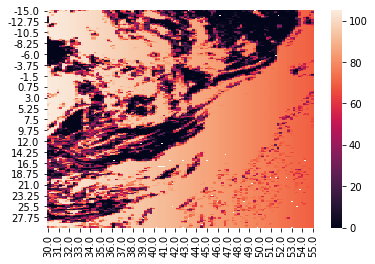

In [223]:
import seaborn as sns
df = pd.DataFrame.from_dict(fractions)
sns.heatmap(df)